In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [4]:
# some functions to deal with image 
def imload(image_name):       
    # a function to load image and transfer to Pytorch Variable.
    image = Image.open(image_name)
    alpha = None
    # content 이미지의 배경 요소 제거 및 저장
    # mode : https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes

    if len(image.getbands()) == 4: # mode가 RGBA인 경우      
        alpha = image.getchannel('A')
    elif len(image.getbands()) == 1: # mode가 P인 경우
        image = image.convert("RGBA")
        alpha = image.getchannel('A')
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),#Converts (H x W x C) of[0, 255] to (C x H x W) of range [0.0, 1.0]. 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])    
    with torch.no_grad():
        image = Variable(transforms.ToTensor()(image))  
        # image = Variable(transform(image)) # 정규화=>색깔 바뀜
    image = image.unsqueeze(0) 
    return image, alpha

In [5]:
class FeatureExtracter(nn.Module):
    # a nn.Module class to extract a intermediate activation of a Torch module
    def __init__(self,submodule):
        super().__init__()
        self.submodule = submodule
    def forward(self,image,layers):
        features = []
        for i in range(layers[-1]+1):
            image = self.submodule[i](image)  
            if i in layers :
                features.append(image)       
        return features 

In [6]:
class GramMatrix(nn.Module):     
    # a nn.Module class to build gram matrix as style feature
    def forward(self,style_features): 
        gram_Matrices=[]
        for feature in style_features:
            n,f,h,w = feature.size()
            F = feature.resize(n*f,h*w)
            gram_Matrices.append(( F @ F.t()).div_(2*n*f*h*w)) 
        return gram_Matrices

In [7]:
class Stylize(nn.Module): 
    # net 
    def forward(self,x):
        s_feats = feature(x,STYLE_LAYER)   
        s_feats = gram(s_feats)
        c_feats = feature(x,CONTENT_LAYER)
        return s_feats,c_feats

In [8]:
def totalloss(style_refs,content_refs,style_features,content_features,style_weight,content_weight):
    # # compute total loss 
    # style_loss_list = [l2loss(style_features[i],style_refs[i]) for i in range(len(style_features))] 
    
    # #a small trick to balance the influnce of diffirent style layer
    # mean_loss = sum(style_loss_list).item()/len(style_features)
    
    # style_loss = sum([(mean_loss/l.item())*l*STYLE_LAYER_WEIGHTS[i] 
    #                 for i,l in enumerate(style_loss_list)])/len(style_features)                             
    # '''
    # style_loss = 0
    # for i, loss in enumerate(style_loss_list):
    #     N, M = style_features[i].size()
    #     style_loss += (loss / (4 * ( N**2 * M**2 )))  *  STYLE_LAYER_WEIGHTS[i]
    # '''
    style_loss = sum([l2loss(style_features[i],style_refs[i]) 
                    for i in range(len(style_refs))])  /  len(style_refs)
    content_loss = sum([l2loss(content_features[i],content_refs[i]) 
                    for i in range(len(content_refs))])  /  len(content_refs)

    total_loss = style_weight*style_loss   +   content_weight*content_loss 
    return total_loss

In [9]:
def reference(style_img,content_img):
    # a function to compute style and content refenrences as used for loss
    style_refs = feature(style_img,STYLE_LAYER)
    style_refs = gram(style_refs)
    style_refs = [Variable(i.data) for i in style_refs] 
    content_refs = feature(content_img,CONTENT_LAYER)
    content_refs = [Variable(i.data) for i in content_refs]
    return style_refs,content_refs

In [10]:
# init paramters
learning_rate = 0.05
style_weight = 1e5
content_weight = 1e-1
num_iters = 1000

# load  pretrained squeezeNet and use the first sequential
model = models.squeezenet1_1(pretrained=True)
submodel = next(model.children())

# set net parameter
STYLE_LAYER =[1,2,3,4,6,7,9]# could add more,maximal to 12  
# STYLE_LAYER_WEIGHTS = [2,2,1,1,1,7,7]# this should be small length as STYLE_LAYER 
CONTENT_LAYER = [1] 

# build net component
gram = GramMatrix()
feature = FeatureExtracter(submodel)  
l2loss = nn.MSELoss(reduction='sum') 
stylize = Stylize()             
toImage = transforms.ToPILImage()

In [11]:
def getTransformedImg(style_img, content_img):
    train_img = Variable(content_img,requires_grad = True) 
    optimizer = optim.Adam([train_img], lr = learning_rate)
    style_refs,content_refs = reference(style_img,content_img)                                                       
    for i in range(num_iters):
        optimizer.zero_grad()
        train_img.data.clamp_(-1,1)  
        style_features,content_features = stylize(train_img)  
        loss = totalloss(style_refs,content_refs,style_features,content_features,style_weight,content_weight) 
        loss.backward() 
        optimizer.step() 
    return train_img

In [12]:
# 모델 성능 평가용
def getFinal():
    content_location = "/content/drive/MyDrive/Colab Notebooks/data/content/character_zombie_attack0.png"       # alpha 있고 P 모드
    #content_location = '/content/drive/MyDrive/Colab Notebooks/data/content/YellowLabradorLooking_new.jpg'     # alpha 없고 rgb 모드
    #content_location = '/content/drive/MyDrive/Colab Notebooks/data/content/jumpATK_02.png'                    # alpha 있고 rgba 모드
    style_location = "/content/drive/MyDrive/Colab Notebooks/data/style/Vassily_Kandinsky,_1913_-_Composition_7.jpg"

    style_tensor, _ = imload(style_location)
    content_tensor, alpha = imload(content_location)
    n, c, h, w = content_tensor.size() 
    
    styledImage_tensor = getTransformedImg(style_tensor, content_tensor) 
    styledImage = toImage(styledImage_tensor[0].data)    
    if alpha is not None: 
        styledImage.putalpha(alpha)
    # styledImage.save("/content/drive/MyDrive/Colab Notebooks/data/test.png")
    return styledImage

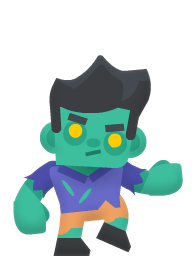

In [13]:
# origin
origin = Image.open("/content/drive/MyDrive/Colab Notebooks/data/content/character_zombie_attack0.png")
origin

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


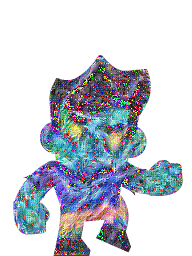

In [14]:
# num_iters = 1000, learning_rate = 0.1 input image size = (256, 256) 약 8분 소요
final = getFinal()
final

In [15]:
def model_auto(style_folder_list, content_folder_list):
  # ★사용 모델명★
  model_name = "SqueezeNet"
  for SF_index, SF_value in enumerate(style_folder_list):
    style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
    style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc
    style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
    for SI_index, SI_value in enumerate(style_images_list):
      style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    #   # 스타일 이미지 선택
    #   print(SI_value)
    #   style = style_tf(Image.open(str(SI_value)))
    #   style = style.to(device).unsqueeze(0)

      # 콘텐트 폴더 리스트
      for CF_index, CF_value in enumerate(content_folder_list):

        #콘텐트 이미지 리스트
        content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
        content_images_list = natsort.natsorted(content_images_list)

        # 스타일 전이
        for CI_index, CI_value in enumerate(content_images_list):
          # location = CI_value

          # 저장 경로 생성
          asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
          asset_name = os.path.split(CI_value)

          save_folder_model = styled_location + model_name
          save_folder_style = save_folder_model + "/" + style_folder_name[1]
          save_folder_style_index = save_folder_style + "/" + style_image_name[1]
          save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
          createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
          createFolder(save_folder_style) # horror, ice, dark
          createFolder(save_folder_style_index) # horror1, horror2, horror3
          createFolder(save_folder_style_index_content) # goblin, zombie, male

          save_path = save_folder_style_index_content + "/"
          save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

          # 이미 있는 파일이면 건너뛰기
          if os.path.exists(save_path):
            continue
          else:
            content_location = str(CI_value)
            style_location = str(SI_value)
            style_tensor, _ = imload(style_location)
            content_tensor, alpha = imload(content_location)
            styledImage_tensor = getTransformedImg(style_tensor, content_tensor) 
            styledImage = toImage(styledImage_tensor[0].data*0.5+0.5)
            if alpha is not None: 
                styledImage.putalpha(alpha)
            styledImage.save(save_path)